# Demo - Adversarial Robustness

Reference: [get_started_pytorch.py](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py)

In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 983kB 8.2MB/s 
     |████████████████████████████████| 3.4MB 33.8MB/s 
     |████████████████████████████████| 25.3MB 120kB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

## Main

In [2]:
import json
import pprint

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from art.attacks.poisoning.perturbations.image_perturbations import (
    add_pattern_bd, add_single_bd)
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

%matplotlib inline

def plot_single_sample(image, title=""):
    plt.imshow(image, cmap="gray")
    plt.clim(0, 1)
    plt.axis("off")
    plt.title(title)
    plt.show()


def plot_samples(data, labels, Nr=3, Nc=3, figsize=(6, 6), cmap="gray"):
    fig, axs = plt.subplots(Nr, Nc, figsize=figsize)
    for i in range(Nr * Nc):
        try:
            image = data[i]
            title = f"Prediction: {labels[i]}"
        except IndexError:
            image = np.ones((8, 8))
            title = ""

        ax = axs[i // Nc][i % Nc]
        ip = ax.imshow(image, cmap=cmap)
        ip.set_clim(0, 1)
        ax.axis("off")
        ax.set_title(title)
    plt.show()


def generate_backdoor(
    x_clean, y_clean, percent_poison, backdoor_type="pattern", sources=np.arange(10), targets=(np.arange(10) + 1) % 10
):
    """
    Creates a backdoor in MNIST images by adding a pattern or pixel to the image and changing the label to a targeted
    class. Default parameters poison each digit so that it gets classified to the next digit.

    :param x_clean: Original raw data
    :type x_clean: `np.ndarray`
    :param y_clean: Original labels
    :type y_clean:`np.ndarray`
    :param percent_poison: After poisoning, the target class should contain this percentage of poison
    :type percent_poison: `float`
    :param backdoor_type: Backdoor type can be `pixel` or `pattern`.
    :type backdoor_type: `str`
    :param sources: Array that holds the source classes for each backdoor. Poison is
    generating by taking images from the source class, adding the backdoor trigger, and labeling as the target class.
    Poisonous images from sources[i] will be labeled as targets[i].
    :type sources: `np.ndarray`
    :param targets: This array holds the target classes for each backdoor. Poisonous images from sources[i] will be
                    labeled as targets[i].
    :type targets: `np.ndarray`
    :return: Returns is_poison, which is a boolean array indicating which points are poisonous, x_poison, which
    contains all of the data both legitimate and poisoned, and y_poison, which contains all of the labels
    both legitimate and poisoned.
    :rtype: `tuple`
    """

    max_val = np.max(x_clean)

    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        if backdoor_type == "pattern":
            imgs_to_be_poisoned = add_pattern_bd(x=imgs_to_be_poisoned, pixel_value=max_val)
        elif backdoor_type == "pixel":
            imgs_to_be_poisoned = add_single_bd(imgs_to_be_poisoned, pixel_value=max_val)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [3]:
print(f"Pytorch Version: {torch.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.device_count() > 0:
    print(f"Found GPU at: {torch.cuda.get_device_name(0)}")

Pytorch Version: 1.8.1+cu101
Device: cuda
Found GPU at: Tesla T4


In [4]:
# Read MNIST dataset (x_raw contains the original images):
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

n_train = np.shape(x_raw)[0]
num_selection = 5000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

## Poison data
Add some pixels in the bottom right corner and relabel as "n+1" from "n"

In [5]:
# Poison training data
perc_poison = 0.33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, perc_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, perc_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data so poison is not together
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

In [11]:
# Swap axes to PyTorch's NCHW format
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

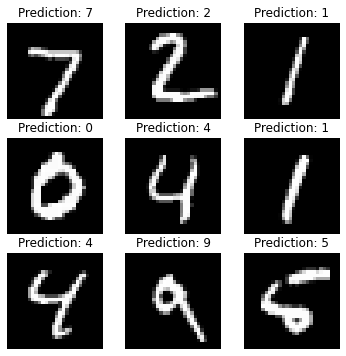

In [12]:
i = 0
plot_samples(x_test[i: i + 9, 0], np.argmax(y_test[i: i + 9], axis=1))

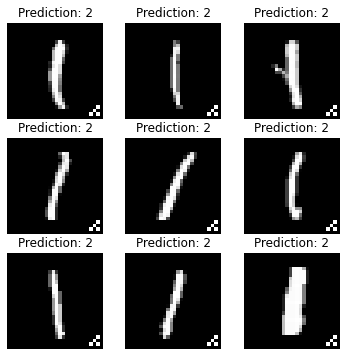

In [10]:
i = np.argwhere(is_poison_test == 1).squeeze()[1000]
plot_samples(x_test[i: i + 9, 0], np.argmax(y_test[i: i + 9], axis=1))

## Train

In [ ]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [ ]:
# Evaluate the classifier on poisonous data
preds = np.argmax(classifier.predict(x_test[is_poison_test]), axis=1)
acc = np.sum(preds == np.argmax(y_test[is_poison_test], axis=1)) / y_test[is_poison_test].shape[0]
print(f"Accuracy on poisonous test data/Effectiveness of poison: {acc * 100:.2f}%")

# Evaluate the classifier on clean data
preds = np.argmax(classifier.predict(x_test[is_poison_test == 0]), axis=1)
acc = np.sum(preds == np.argmax(y_test[is_poison_test == 0], axis=1)) / y_test[is_poison_test == 0].shape[0]
print(f"Accuracy on clean test data: {acc * 100:.2f}%")

Accuracy on poisonous test data/Effectiveness of poison: 94.36%
Accuracy on clean test data: 95.77%


In [ ]:
# Evaluate the classifier on test data
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print(f"Accuracy on test data: {acc * 100:.2f}%")

Accuracy on test data: 95.30%


## Calling poisoning defence

In [ ]:
# Calling poisoning defence:
defence = ActivationDefence(classifier, x_train, y_train)

# End-to-end method:
print("------------------- Results using size metric -------------------")
print(defence.get_params())
defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")
print()

------------------- Results using size metric -------------------
{'nb_clusters': 2, 'clustering_method': 'KMeans', 'nb_dims': 10, 'reduce': 'PCA', 'cluster_analysis': 'smaller', 'generator': None}



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Visualize clusters


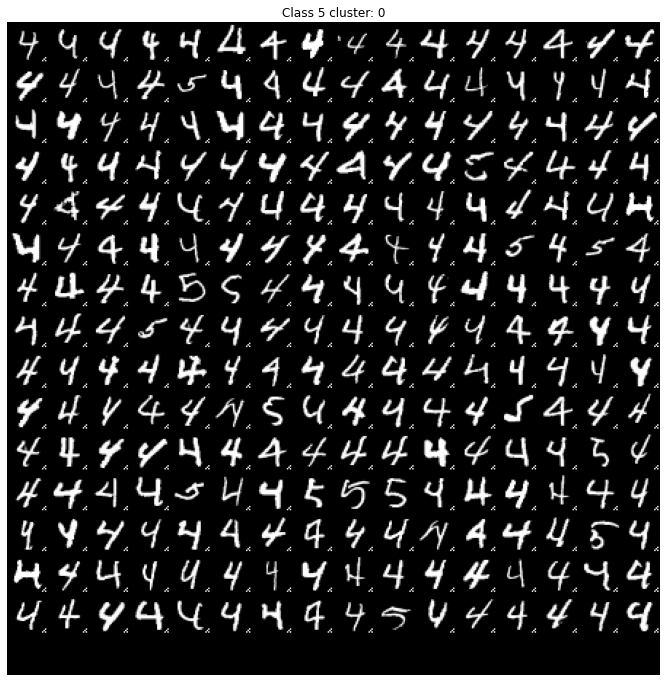

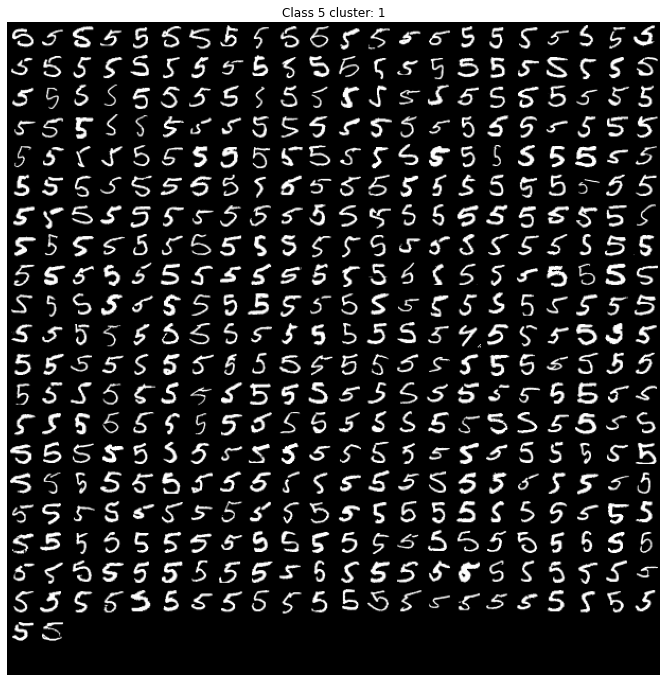

In [ ]:
# Visualize clusters:
print("Visualize clusters")
sprites_by_class = defence.visualize_clusters(
    x_train.transpose((0, 2, 3, 1)), "mnist_poison_demo")
# Show plots for clusters of class 5
n_class = 5

fig = plt.figure(figsize=(12, 12))
plt.imshow(sprites_by_class[n_class][0])
plt.title("Class " + str(n_class) + " cluster: 0")
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(12, 12))
plt.imshow(sprites_by_class[n_class][1])
plt.title("Class " + str(n_class) + " cluster: 1")
plt.axis("off")
plt.show()

In [ ]:
# Evaluate method when ground truth is known:
is_clean = is_poison_train == 0
confusion_matrix = defence.evaluate_defence(is_clean)
print("Evaluation defence results for size-based metric: ")
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label])

Evaluation defence results for size-based metric: 
class_0
{'FalseNegative': {'denominator': 261, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 529, 'numerator': 50, 'rate': 9.45},
 'TrueNegative': {'denominator': 529, 'numerator': 479, 'rate': 90.55},
 'TruePositive': {'denominator': 261, 'numerator': 261, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 265, 'numerator': 15, 'rate': 5.66},
 'FalsePositive': {'denominator': 539, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 539, 'numerator': 539, 'rate': 100.0},
 'TruePositive': {'denominator': 265, 'numerator': 250, 'rate': 94.34}}
class_2
{'FalseNegative': {'denominator': 250, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 508, 'numerator': 124, 'rate': 24.41},
 'TrueNegative': {'denominator': 508, 'numerator': 384, 'rate': 75.59},
 'TruePositive': {'denominator': 250, 'numerator': 250, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 256, 'numerator': 57, 'rate':

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
